# COMPSCI 714 - Assignment 2

The goal of this assignment is to evaluate your ability to **implement, train and evaluate a specified CNN architecture** on a specific dataset, and make changes to improve the baseline performance.

In the first part of the assignment, you will need to implement the LeNet-5 CNN architecture and train it on the CIFAR-10 dataset. This will give you a baseline performance.

In the second part of the assignment, you will need to implement changes to improve this baseline.

**Name**:

**UPI**:

**Student ID**:

## **Part 1: Implementing and evaluating the baseline** - 5 marks

For the first part of the assignment, you have to implement the LeNet-5 architecture (from [LeCun et al., 1998](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)), and train it on the CIFAR10 dataset. 

![LeNet5 Architecture](image-5.png)

## Task 1.1: Load, prepare and split the data - 1 mark

For this assignment, you will use the CIFAR-10 dataset. It consists of 60000 32x32 colour images (RGB) divided in 10 mutually exclusive classes, with 6000 images per class. There are 50000 training images and 10000 test images. More information about the dataset (including the different classes with sample images) can be found at the following links.
- [Link to CIFAR-10 homepage](https://www.cs.toronto.edu/~kriz/cifar.html)
- [Link to the documentation on Paper With CodeLinks to an external site.](https://paperswithcode.com/dataset/cifar-10)

**Task deliverables**:
- Load the train and test datasets from `torchvision.datasets.CIFAR10`.
- Normalise the pixel values between 0 and 1.
- Split the train set in train and validation sets, with 80% of the data for training and 20% for validation.
- Create dataloaders with a batch size of 32. 

Notes:
- You can split the training set randomly, i.e., it is not required to handle any potential class imbalance for this task.

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Setup training data
train_data_full = datasets.CIFAR10(
            root="data",
            train=True,
            download=True,
            transform=ToTensor(), # convert to tensor and normalize between range 0 and 1
            target_transform=None
)

# Setup testing data
test_data = datasets.CIFAR10(
            root="data",
            train=False,
            download=True,
            transform=ToTensor()
)

# Split train and valid data
torch.manual_seed(42)
train_size = int(0.8 * len(train_data_full))  
valid_size = len(train_data_full) - train_size  
train_data, valid_data = torch.utils.data.random_split(train_data_full, [train_size, valid_size])

# Create dataloader with batch size 32
BATCH_SIZE=32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Check out batch contents
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of valid dataloader: {len(valid_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1250 batches of 32
Length of valid dataloader: 313 batches of 32
Length of test dataloader: 313 batches of 32


## Task 1.2: Implementing and training the LeNet-5 model - 3 marks

The architecture you need to implement is specified as follows:

Layers: [5x5 Conv] -> [2x2 Pooling] -> [5x5 Conv] -> [2x2 Pooling] -> [FC 120] -> [FC 84] -> [FC 10]
The convolution layers have no stride (i.e., stride = 1) and valid padding.
The pooling layers use average pooling with no stride and valid padding.
All convolution layers and fully-connected layers have a ReLU activation (except the output layer).
The input image shape is 32x32x3 (RGB images).

**Task deliverables**:
- Define a model that implements the LeNet-5 architecture described above.
- Train the model using the following settings:
    - Optimiser: ADAM
    - Learning rate = 0.001
    - Loss: categorical crossentropy
    - Metric: accuracy
    - Epochs: 20
- Display the training and validation loss and accuracy curves.
- Compute and display the accuracy of the model on the test set.

Important notes: 
- It is recommended to use a Colab GPU runtime (or your own GPU if it is setup for it) to train the model.
- If using PyTorch, be mindful of the combination of output layer activation function and loss you use (see Lectutorial 3).

In [3]:
# Setup device agonistic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

In [4]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),  # Conv1
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),                               # Pool1

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # Conv2
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)                                # Pool2
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       # Flatten
            nn.Linear(in_features=16*5*5, out_features=120),    # FC1
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        # FC2
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)          # FC3 (Output layer, no activation)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

model = LeNet5()

In [5]:
# # Get summary of the model
# from torchsummary import summary
# model.to("cpu")
# summary(model, (3, 32, 32), device="cpu")

In [7]:
# Training function returning train and valid losses and evaluation metrics
def train(model, optimizer, loss_fn, eval_metric, train_loader, valid_loader, n_epochs):
    train_losses = []
    train_eval_metrics = []
    valid_losses = []
    valid_eval_metrics= []

    for epoch in range(n_epochs):

        #Training
        eval_metric.reset() # Reset the eval metric
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            eval_metric.update(y_train_pred, y_train_batch) # Update eval metric for training
            optimizer.step()
            optimizer.zero_grad()
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)
        # Calculte and store training eval metric for this epoch
        epoch_training_eval_metric = eval_metric.compute().item()
        train_eval_metrics.append(epoch_training_eval_metric)

        # Model evaluation
        model.eval()
        eval_metric.reset() # Reset the eval metric
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()  # Update eval metric for validation
                eval_metric.update(y_valid_pred, y_valid_batch)
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_losses.append(mean_epoch_valid_loss)
        # Calculte and store validation eval metric for this epoch
        epoch_valid_eval_metric = eval_metric.compute().item()
        valid_eval_metrics.append(epoch_valid_eval_metric)

        print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Training Eval Metric: {epoch_training_eval_metric:.4f}, Valid Eval Metric: {epoch_valid_eval_metric:.4f}")

    return (train_losses, valid_losses, train_eval_metrics, valid_eval_metrics)

In [8]:
# Function to evaluate the model on the test set (evaluation metric only)
def evaluate_test_set(model, eval_metric, test_loader, metric_print):
    model.eval()
    eval_metric.reset() # Reset the eval metric
    test_loss = 0.
    with torch.no_grad():
      model.eval()
      eval_metric.reset() # Reset the eval metric
      total_test_loss = 0.
      with torch.no_grad():
          for X_test_batch, y_test_batch in test_loader:
              X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
              y_test_logits = model(X_test_batch)
              y_test_preds = torch.argmax(y_test_logits, dim=1)
              eval_metric.update(y_test_preds, y_test_batch)
      total_test_eval_metric = eval_metric.compute().item()

      print(f"Test {metric_print}: {total_test_eval_metric:.4f}")

In [9]:
# Define loss (cross entropy), evaluation metric (accuracy), optimiser, number of epochs, and launch the training
import torchmetrics
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5
train_losses, valid_losses, train_accuracy, valid_accuracy = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/5, Training Loss: 1.8291, Valid Loss: 1.6406
Epoch 1/5, Training Eval Metric: 0.3243, Valid Eval Metric: 0.4102
Epoch 2/5, Training Loss: 1.5563, Valid Loss: 1.4686
Epoch 2/5, Training Eval Metric: 0.4353, Valid Eval Metric: 0.4785
Epoch 3/5, Training Loss: 1.4575, Valid Loss: 1.4334
Epoch 3/5, Training Eval Metric: 0.4757, Valid Eval Metric: 0.4869
Epoch 4/5, Training Loss: 1.3868, Valid Loss: 1.3757
Epoch 4/5, Training Eval Metric: 0.5003, Valid Eval Metric: 0.5051
Epoch 5/5, Training Loss: 1.3307, Valid Loss: 1.3460
Epoch 5/5, Training Eval Metric: 0.5235, Valid Eval Metric: 0.5159


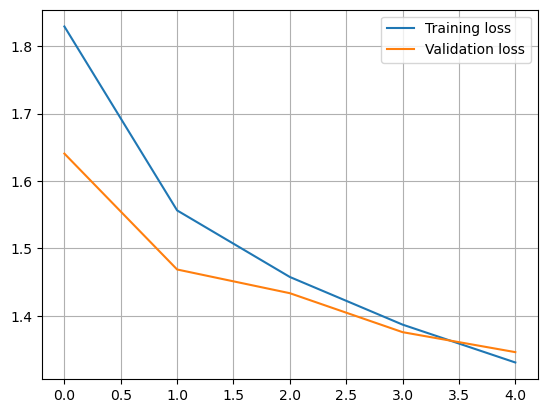

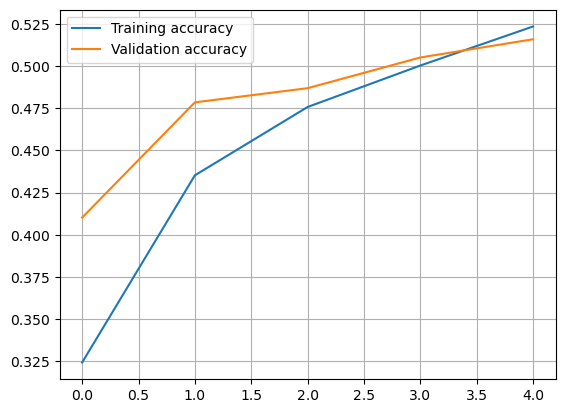

In [10]:
# Plot losses and accuracy
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.grid()
plt.legend()
plt.show()
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(valid_accuracy, label='Validation accuracy')
plt.grid()
plt.legend()
plt.show()

In [11]:
# Evalutes the model on the test set
evaluate_test_set(model, accuracy, test_loader, "accuracy")

Test accuracy: 0.5123


## Task 1.3: Discuss the model's performance - 1 mark

**Task deliverable**:
- Discuss the model's perfomance using the architecture and training settings in Task 1.2 (100 words max). 

Test accuracy is only around 0.5865, which is not good enough.

# Part 2: Improve on the baseline - 5 marks

## Task 2.1: Improve the accuracy of the model - 2.5 marks

Starting from the LeNet-5 architecture you used in part 1, implement *at least* 3 changes to improve the performance of the model. For this task, the model's performance is primarily measured as the validation and test accuracy for the final model. 

**Task deliverables**: 
- Implement at least 3 changes in your model or the training process from Task 1, to improve the performance of the trained model.
- Show experimentally that your new model has a better performance than the baseline.
- 1 mark out of 2.5 is given for the level of accuracy of your improved model:
    - 1 mark if your model's test >= 70%.
    - 0.5 mark if your model's test accuracy is >= 60% and < 70%.
    - 0 mark if your model's test accuracy is < 60%.

*Notes*: 
- Each change should focus on different aspect of the model and/or training process. I.e., if change 1 is adding 1 extra convolution layer and change 2 is adding 2 extra convolution layers, they are not considered different change choices. Both are about adding more convolution layers in the network.
- You do not need to train a much deeper network to get a better performance. I.e., try to keep the training time reasonable to be able to experiment with several choices. 
- You can use what we covered in past tutorials, as well as your own research to make choices about what changes are likely to improve the model's performance.
- For this task, we use accuracy to evaluate the model's performance, but remember that a model's performance can include other criteria depending on the task and your goal (e.g., reduced overfitting, lesser training time with similar accuracy, better recall on imbalanced data, etc). 

In [77]:
# Let's redefine our model and try it again
import torch
import torch.nn as nn

class LeNet5_V1(nn.Module):
    def __init__(self):
        super(LeNet5_V1, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # Conv1 (2x2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Conv2 (3x3)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Conv2 (3x3)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 240),  
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(240, 160),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(160, 110),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(110, 10)
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        #print(f"output shape is: {x.shape}")
        return x

model = LeNet5_V1()

In [78]:
# Define loss (cross entropy), evaluation metric (accuracy), optimiser, number of epochs, and launch the training
model.to(device)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
n_epochs = 20
train_losses, valid_losses, train_accuracy, valid_accuracy = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/20, Training Loss: 1.4011, Valid Loss: 1.1172
Epoch 1/20, Training Eval Metric: 0.4865, Valid Eval Metric: 0.5977
Epoch 2/20, Training Loss: 1.0210, Valid Loss: 0.9814
Epoch 2/20, Training Eval Metric: 0.6390, Valid Eval Metric: 0.6512
Epoch 3/20, Training Loss: 0.8631, Valid Loss: 0.9055
Epoch 3/20, Training Eval Metric: 0.7009, Valid Eval Metric: 0.6934
Epoch 4/20, Training Loss: 0.7597, Valid Loss: 0.7840
Epoch 4/20, Training Eval Metric: 0.7372, Valid Eval Metric: 0.7252
Epoch 5/20, Training Loss: 0.6815, Valid Loss: 0.7822
Epoch 5/20, Training Eval Metric: 0.7649, Valid Eval Metric: 0.7268
Epoch 6/20, Training Loss: 0.6102, Valid Loss: 0.7509
Epoch 6/20, Training Eval Metric: 0.7893, Valid Eval Metric: 0.7394
Epoch 7/20, Training Loss: 0.5498, Valid Loss: 0.8880
Epoch 7/20, Training Eval Metric: 0.8105, Valid Eval Metric: 0.7197
Epoch 8/20, Training Loss: 0.4939, Valid Loss: 1.0403
Epoch 8/20, Training Eval Metric: 0.8301, Valid Eval Metric: 0.6955
Epoch 9/20, Training Los

In [79]:
# Evalutes the model on the test set
evaluate_test_set(model, accuracy, test_loader, "accuracy")

Test accuracy: 0.7688


## Task 2.2: Report on your changes - 2.5 marks

**Task deliverables**:
- Write a brief report (max. 300 words), answering the following questions:
    - Why do you think the changes you made in Task 2.1 led to a higher test accuracy?
    - What else could you try to improve your model if you had more time and/or more computational resources?